My hypothesis:
    
* Increase in Atlantic inflow brings warm and saltier water in Arctic which change the density variation in the intermediate/deep layer. That's why the circulation changes direction.


This notebook test this hypothesis in **EXH001**.

(Results for other runs are in /ocean/xiaoxiny/research/Analysis_local/phy_field)

In [3]:
import glob
import datetime
import scipy.io
import numpy as np
import seaborn as sb
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
from mpl_toolkits.basemap import Basemap, cm, addcyclic
% matplotlib inline

In [4]:
import seawater as sw

In [5]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [6]:
mesh=nc.Dataset('/ocean/xiaoxiny/research/data/mesh_mask_anha4_201509.nc')
e1t= mesh.variables['e1t'][0,:]  # dx
e2t= mesh.variables['e2t'][0,:]  # dy 
e3t= mesh.variables['e3t'][0,:]
tmask= mesh.variables['tmask'][0,:]

bathy=nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=bathy.variables['Bathymetry'][400:,:]

In [7]:
dfield_dx = np.zeros((2,bathy.shape[0],bathy.shape[1]))
dfield_dx.shape

(2, 400, 544)

In [8]:
def geostro(lat,Pressure,rho): 
    '''    
    ug = -dP_y/(f*rho)
    vg = dP_x/(f*rho)
    '''
    dP_x, dP_y = gradient(Pressure);
    f = 1e-4*np.sin(lat*np.pi/180.0);
        
    ug = -dP_y/(f*rho);
    vg = dP_x/(f*rho);
    return ug, vg

def gradient(Pressure):
    '''    
    ug = -dP_y/(f*rho)
    vg = dP_x/(f*rho)
    This function calculate dP_dx, dP_dy
    '''
    dP = d_(Pressure);
    dx = e1t;
    dy = e2t;
    dP_x = dP[0,:]/dx;
    dP_y = dP[1,:]/dy;
    return dP_x, dP_y

def d_(field):
    '''    
    ug = -dP_y/(f*rho)
    vg = dP_x/(f*rho)
    In order to calculate dP_dx, dP_dy, we need dP. This function does this job.
    '''
    dfield= np.zeros((2,field.shape[0],field.shape[1]))
    # dx
    dfield[0,:, :-1] = field[:, 1:]-field[:, :-1]
    dfield[0,:,-1] = dfield[0,:,-2] # assuming the last two columns have the same dx (and dy)
    # dy
    dfield[1,:-1, :] = field[1:, :]-field[:-1, :]
    dfield[1,-1,:] = dfield[1,-2,:]
    return dfield

In [9]:
def geoflow(model,layer, ssh_key='False'):
    #fig= plt.figure()
    dep = model.variables['deptht'][:]
    print ('>> depth: %s'%dep[layer])
    nav_lat = model.variables['nav_lat'][:]
    nav_lon = model.variables['nav_lon'][:]
    
    P = np.zeros_like(nav_lon)
    for i in range (layer):
        # sum rho through all layers
        temp = model.variables['votemper'][0,i, :, :]
        sal = model.variables['vosaline'][0,i, :, :]
    
        temp[tmask[i,:,:]==0]=np.nan
        t = sw.library.T90conv(temp)
        rho = sw.dens0(sal, t)
        P += rho*9.8*(e3t[i])
        if ssh_key == 'True' and i == 0:
            print ('>> ssh added')
            ssh = model.variables['sossheig'][0,:, :]
            temp = model.variables['votemper'][0,0, :, :]
            sal = model.variables['vosaline'][0,0, :, :]
            rho = sw.dens0(sal, t)
            t = sw.library.T90conv(temp)
            P += rho*9.8*(ssh)
        #plt.scatter(dep[i], P[600,300])#e3t  intergrate/ssh 

    ug, vg = geostro(nav_lat, P, rho)

    Ug=np.copy(ug)
    Vg=np.copy(vg)
    
    # mask too huge value
    Ug[ug[:,:]>0.5] = np.nan
    Vg[ug[:,:]>0.5] = np.nan
    Ug[vg[:,:]>0.5] = np.nan
    Vg[vg[:,:]>0.5] = np.nan
    
    # mask topography
    Ug[tmask[layer,:,:]==0] = np.nan
    Vg[tmask[layer,:,:]==0] = np.nan
    P[tmask[layer,:,:]==0]  = np.nan
    
    return Ug[400:,:],Vg[400:,:],P[400:,:],nav_lat[400:,:],nav_lon[400:,:]

In [10]:
model=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-EXH001_gridT_y2002m12d27.nc')
ssh = model.variables['sossheig'][0,:, :]

In [11]:
# grid for plotting
x1d=np.linspace(0,e1t[400:,0].shape[0],e1t[400:,0].shape[0])
y1d=np.linspace(0,e1t[0,:].shape[0],e1t[0,:].shape[0])
x2d,y2d=np.meshgrid(y1d,x1d)

# cyclonic year

In [12]:
ug_0,vg_0,P_0,nav_lat,nav_lon = geoflow(
    nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-EXH001_gridT_y2002m12d27.nc')
    ,layer=30, ssh_key = 'True')

>> depth: 453.938
>> ssh added


(100, 400)

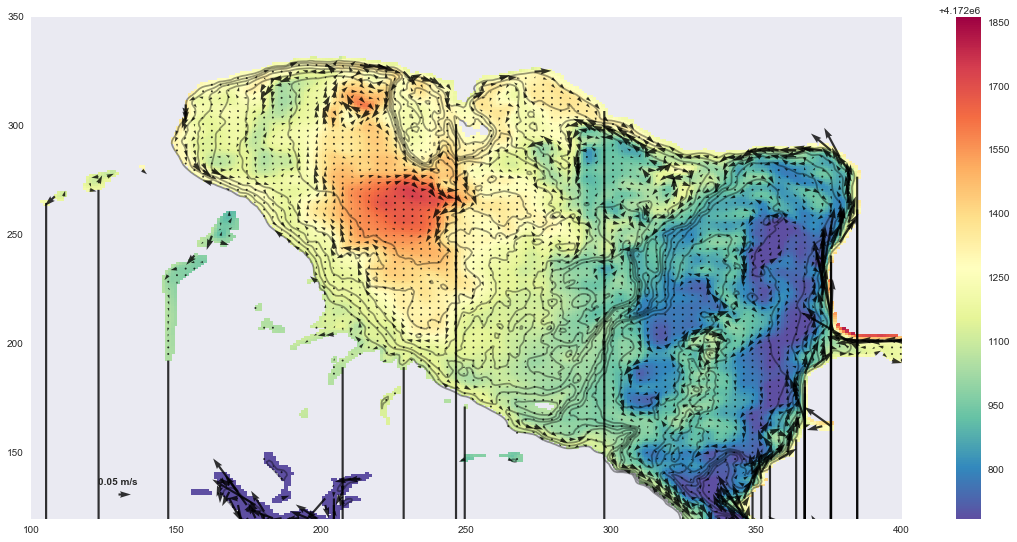

In [13]:
fig = plt.figure(figsize=(13*1.5,6*1.5))
    

plt.pcolor(x2d[:,:], y2d[:,:], np.ma.masked_invalid(P_0[:,:]),cmap='Spectral_r',
           vmin=np.ma.masked_invalid(P_0[:,:]).min()+3000, vmax=np.ma.masked_invalid(P_0[:,:]).max()-200);
plt.colorbar()

#vector
Q=plt.quiver(x2d[::3,::3], y2d[::3,::3], ug_0[::3,::3], vg_0[::3,::3],
           scale=3.5,width=0.0025,color='k',alpha=0.8)
Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.05, '0.05 m/s',fontproperties={'weight': 'bold'})
plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
plt.ylim(120,350)    
plt.xlim(100,400)

# anti-cyclonic year

In [14]:
ug_e,vg_e,P_e,nav_lat,nav_lon = geoflow(
    nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-EXH001_gridT_y2013m12d27.nc')
    ,layer=30, ssh_key= 'True')

>> depth: 453.938
>> ssh added


(100, 400)

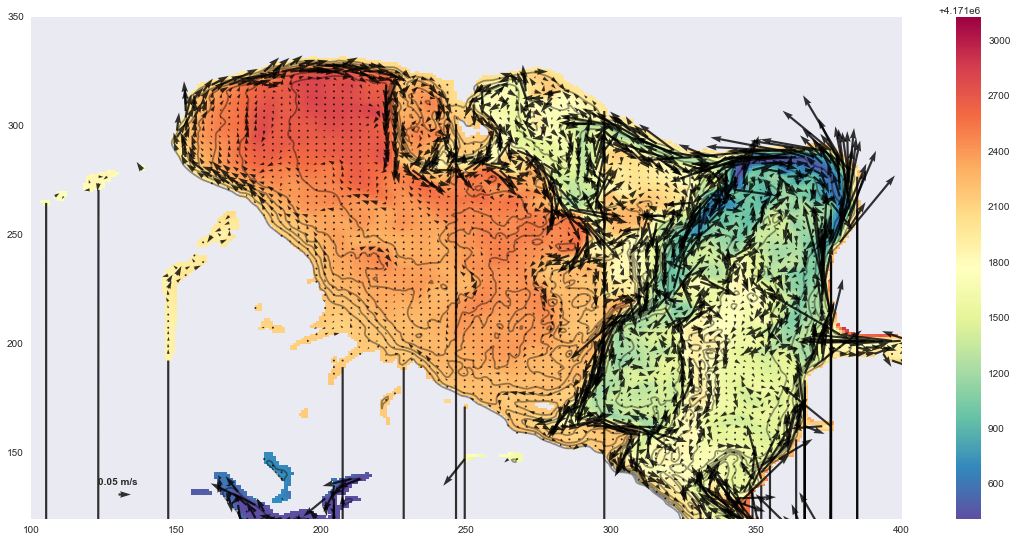

In [15]:
fig = plt.figure(figsize=(13*1.5,6*1.5))
    

plt.pcolor(x2d[:,:], y2d[:,:], np.ma.masked_invalid(P_e[:,:]),cmap='Spectral_r',
           vmin=np.ma.masked_invalid(P_e[:,:]).min()+3200, vmax=np.ma.masked_invalid(P_e[:,:]).max()-150);
plt.colorbar()

#vector
Q=plt.quiver(x2d[::3,::3], y2d[::3,::3], ug_e[::3,::3], vg_e[::3,::3],
           scale=3.5,width=0.0025,color='k',alpha=0.8)
Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.05, '0.05 m/s',fontproperties={'weight': 'bold'})
plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
plt.ylim(120,350)    
plt.xlim(100,400)

(100, 400)

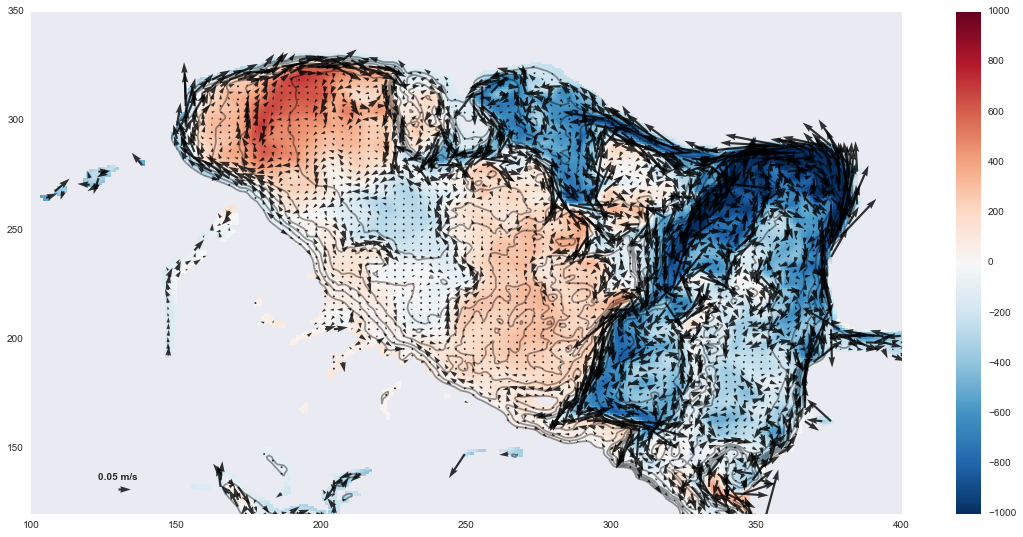

In [16]:
fig = plt.figure(figsize=(13*1.5,6*1.5))
    

plt.pcolor(x2d[:,:], y2d[:,:], np.ma.masked_invalid(P_e[:,:]-P_0[:,:]),
           cmap='RdBu_r',vmin=-1e3,vmax=1e3);
plt.colorbar()


#vector
Q=plt.quiver(x2d[::3,::3], y2d[::3,::3], np.ma.masked_invalid(ug_e[::3,::3]-ug_0[::3,::3]),
             np.ma.masked_invalid(vg_e[::3,::3]-vg_0[::3,::3]),
           scale=3.5,width=0.0025,color='k',alpha=0.8)
Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.05, '0.05 m/s',fontproperties={'weight': 'bold'})
plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
plt.ylim(120,350)    
plt.xlim(100,400)

* great impact on properties of the AW in the Arctic Ocean Boundary Current.

# go deeper

### cyclonic

In [17]:
ug_0,vg_0,P_0,nav_lat,nav_lon = geoflow(
    nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-EXH001_gridT_y2002m12d27.nc')
    ,layer=35, ssh_key = 'True')

>> depth: 1062.44
>> ssh added


(100, 400)

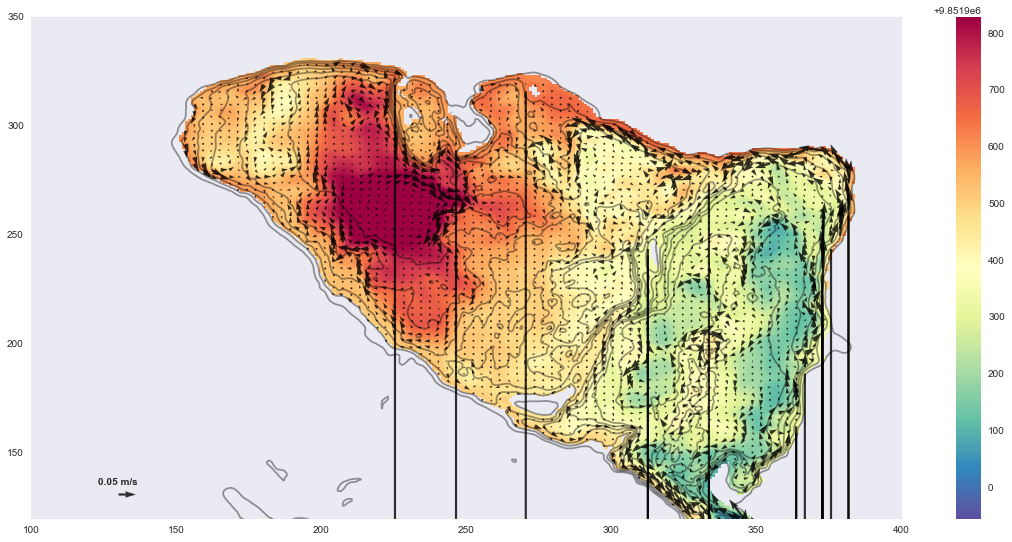

In [18]:
fig = plt.figure(figsize=(13*1.5,6*1.5))
    

plt.pcolor(x2d[:,:], y2d[:,:], np.ma.masked_invalid(P_0[:,:]),cmap='Spectral_r',
           vmin=np.ma.masked_invalid(P_0[:,:]).min()+4500, vmax=np.ma.masked_invalid(P_0[:,:]).max()-200);
plt.colorbar()

#vector
Q=plt.quiver(x2d[::3,::3], y2d[::3,::3], ug_0[::3,::3], vg_0[::3,::3],
           scale=2.5,width=0.0025,color='k',alpha=0.8)
Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.05, '0.05 m/s',fontproperties={'weight': 'bold'})
plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
plt.ylim(120,350)    
plt.xlim(100,400)

### anti-cyclonic

In [19]:
ug_e,vg_e,P_e,nav_lat,nav_lon = geoflow(
    nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-EXH001_gridT_y2013m12d27.nc')
    ,layer=35, ssh_key= 'True')

>> depth: 1062.44
>> ssh added


(100, 400)

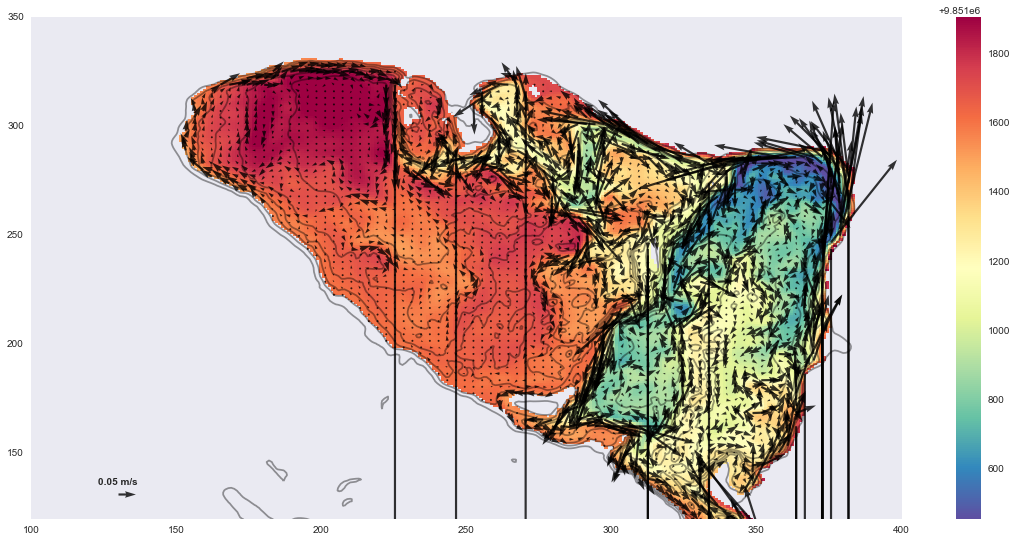

In [20]:
fig = plt.figure(figsize=(13*1.5,6*1.5))
    

plt.pcolor(x2d[:,:], y2d[:,:], np.ma.masked_invalid(P_e[:,:]),cmap='Spectral_r',
           vmin=np.ma.masked_invalid(P_e[:,:]).min()+5000, vmax=np.ma.masked_invalid(P_e[:,:]).max()-100);
plt.colorbar()

#vector
Q=plt.quiver(x2d[::3,::3], y2d[::3,::3], ug_e[::3,::3], vg_e[::3,::3],
           scale=2.5,width=0.0025,color='k',alpha=0.8)
Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.05, '0.05 m/s',fontproperties={'weight': 'bold'})
plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
plt.ylim(120,350)    
plt.xlim(100,400)

(100, 400)

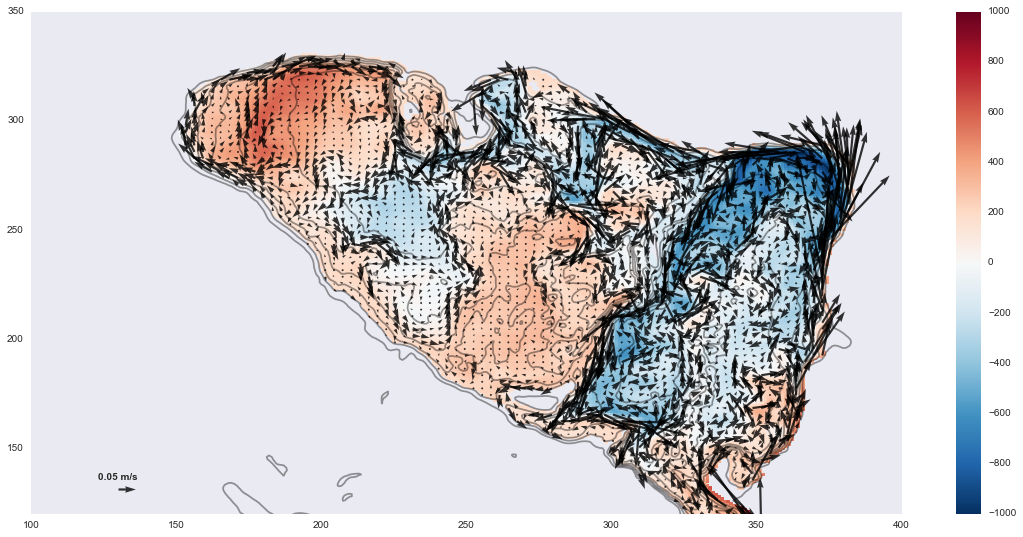

In [21]:
fig = plt.figure(figsize=(13*1.5,6*1.5))
    

plt.pcolor(x2d[:,:], y2d[:,:], np.ma.masked_invalid(P_e[:,:]-P_0[:,:]),
           cmap='RdBu_r',vmin=-1e3,vmax=1e3);
plt.colorbar()


#vector
Q=plt.quiver(x2d[::3,::3], y2d[::3,::3], np.ma.masked_invalid(ug_e[::3,::3]-ug_0[::3,::3]),
             np.ma.masked_invalid(vg_e[::3,::3]-vg_0[::3,::3]),
           scale=2.5,width=0.0025,color='k',alpha=0.8)
Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.05, '0.05 m/s',fontproperties={'weight': 'bold'})
plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
plt.ylim(120,350)    
plt.xlim(100,400)

# ssh-only

### cyclonic year

>> depth: 1.54138
>> ssh added


(100, 400)

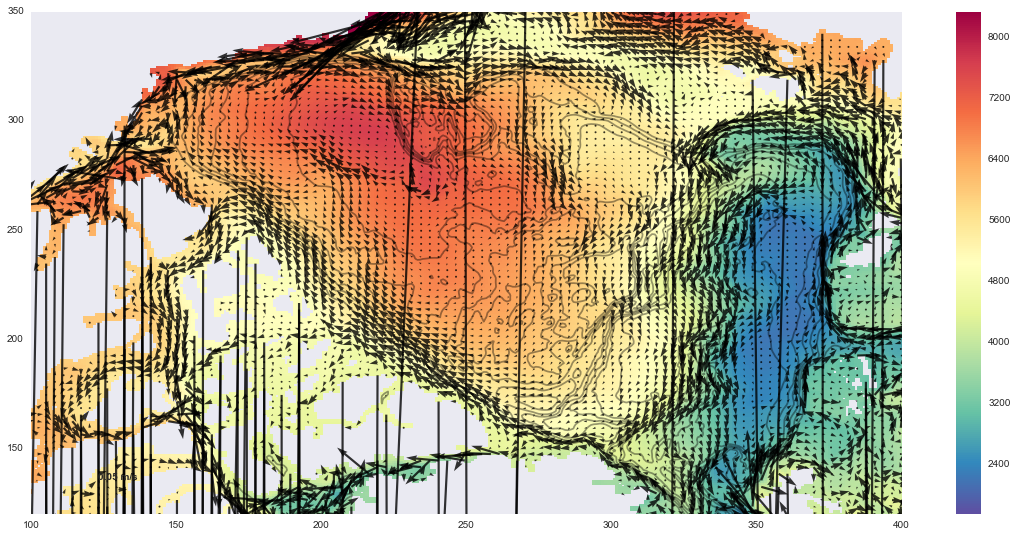

In [38]:
ug_0,vg_0,P_0,nav_lat,nav_lon = geoflow(
    nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-EXH001_gridT_y2002m12d27.nc')
    ,layer=1, ssh_key = 'True')


fig = plt.figure(figsize=(13*1.5,6*1.5))
    

plt.pcolor(x2d[:,:], y2d[:,:], np.ma.masked_invalid(P_0[:,:]),cmap='Spectral_r',
           vmin=np.ma.masked_invalid(P_0[:,:]).min()+1000, vmax=np.ma.masked_invalid(P_0[:,:]).max()-12000);
plt.colorbar()

#vector
Q=plt.quiver(x2d[::3,::3], y2d[::3,::3], ug_0[::3,::3], vg_0[::3,::3],
           scale=5,width=0.0025,color='k',alpha=0.8)
Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.05, '0.05 m/s',fontproperties={'weight': 'bold'})
plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
plt.ylim(120,350)    
plt.xlim(100,400)

### anti-cyclonic year

>> depth: 1.54138
>> ssh added


(100, 400)

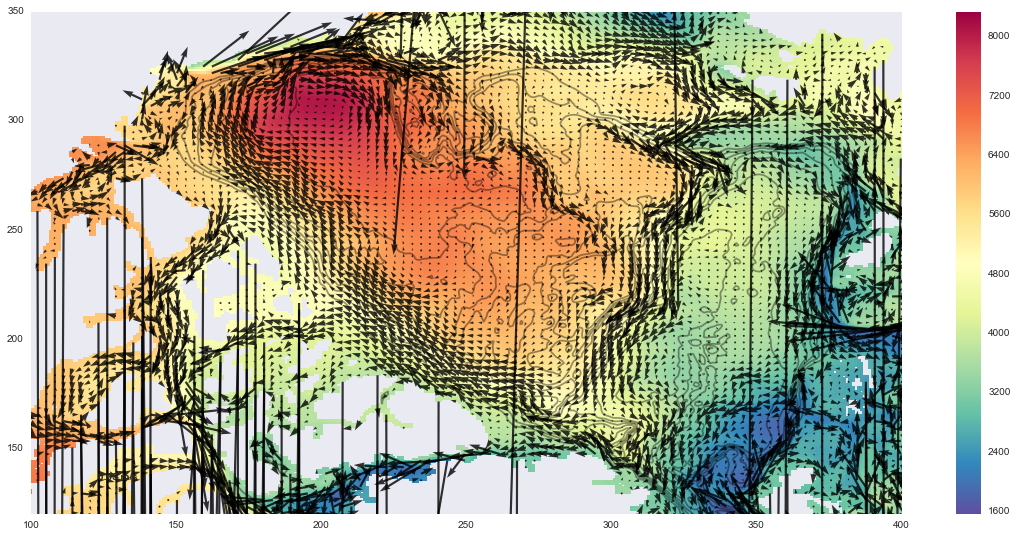

In [39]:
ug_e,vg_e,P_e,nav_lat,nav_lon = geoflow(
    nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-EXH001_gridT_y2013m12d27.nc')
    ,layer=1, ssh_key= 'True')

fig = plt.figure(figsize=(13*1.5,6*1.5))
    

plt.pcolor(x2d[:,:], y2d[:,:], np.ma.masked_invalid(P_e[:,:]),cmap='Spectral_r',
           vmin=np.ma.masked_invalid(P_e[:,:]).min()+3200, vmax=np.ma.masked_invalid(P_e[:,:]).max()-12000);
plt.colorbar()

#vector
Q=plt.quiver(x2d[::3,::3], y2d[::3,::3], ug_e[::3,::3], vg_e[::3,::3],
           scale=5,width=0.0025,color='k',alpha=0.8)
Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.05, '0.05 m/s',fontproperties={'weight': 'bold'})
plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
plt.ylim(120,350)    
plt.xlim(100,400)

(100, 400)

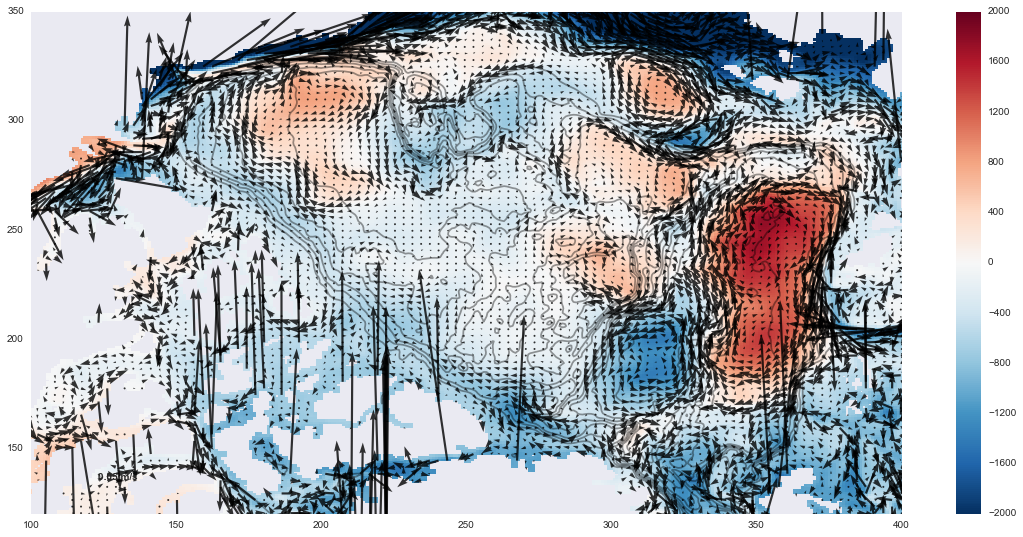

In [45]:
fig = plt.figure(figsize=(13*1.5,6*1.5))
    

plt.pcolor(x2d[:,:], y2d[:,:], np.ma.masked_invalid(P_e[:,:]-P_0[:,:]),
           cmap='RdBu_r',vmin=-2e3,vmax=2e3);
plt.colorbar()


#vector
Q=plt.quiver(x2d[::3,::3], y2d[::3,::3], np.ma.masked_invalid(ug_e[::3,::3]-ug_0[::3,::3]),
             np.ma.masked_invalid(vg_e[::3,::3]-vg_0[::3,::3]),
           scale=5,width=0.0025,color='k',alpha=0.8)
Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.05, '0.05 m/s',fontproperties={'weight': 'bold'})
plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
plt.ylim(120,350)    
plt.xlim(100,400)